## Home Assignment 1 - Parkison Data set
##### Alexandre Sobreira (59451), André Dias (59452), Tiago Rodrigues (49593)

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from statsmodels.api import OLS, add_constant
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error, f1_score, classification_report, confusion_matrix, matthews_corrcoef, precision_score, recall_score, accuracy_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn import tree

In [3]:
# Functions
def StatisticsObjective1(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    
def StatisticsObjective2(test, prediction):
    print("The Precision is: %7.4f" % precision_score(test, prediction))
    print("The Recall is: %7.4f" % recall_score(test, prediction))
    print("The F1 score is: %7.4f" % f1_score(test, prediction))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(test, prediction))
    print("The Confusion maxtrix is:")
    print(pd.DataFrame(confusion_matrix(test, prediction)))
    
def KFoldFunc(function, X, Y, scale):
    kf = KFold(n_splits=10, shuffle = True, random_state=123)
    TRUTH_nfold = None
    PREDS_nfold = None
    for train_index, test_index in kf.split(X):
        X_train_kfold, X_test_kfold = X[train_index], X[test_index]
        y_train_kfold, y_test_kfold = Y[train_index], Y[test_index]
        if scale == True:
            scaler = StandardScaler()
            scaler.fit(X_train_kfold)
            X_train_kfold = scaler.transform(X_train_kfold)
            X_test_kfold = scaler.transform(X_test_kfold)
        model = function.fit(X_train_kfold, y_train_kfold)
        preds_kfold = model.predict(X_test_kfold)
        if TRUTH_nfold is None:
            TRUTH_nfold = y_test_kfold
            PREDS_nfold = preds_kfold
        else:
            TRUTH_nfold = np.hstack((TRUTH_nfold, y_test_kfold))
            PREDS_nfold = np.hstack((PREDS_nfold, preds_kfold))
    return TRUTH_nfold, PREDS_nfold

def RegRegression(function, X_train, X_test, y_train, y_test, rmse_train, rmse_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    model = function.fit(X_train, y_train)
    preds_tr = model.predict(X_train)
    preds_te = model.predict(X_test)
    rmse_train.append(mean_absolute_error(y_train, preds_tr))
    rmse_test.append(mean_absolute_error(y_test, preds_te))
    return rmse_train, rmse_test

def hyperparam_opt(function, statistic, rangenumber, scaler):
    hyper_dict = {}
    hyper_dict['max_depth'] = {}
    hyper_dict['max_leaf_nodes'] = {}
    hyper_dict['min_samples_split'] = {}
    hyper_dict['min_samples_leaf'] = {}
    for i in range(2,rangenumber):
        hyper_dict['max_depth'][i] = []
        hyper_dict['max_leaf_nodes'][i] = []
        hyper_dict['min_samples_split'][i] = []
        hyper_dict['min_samples_leaf'][i] = []
        X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_TRAIN, y_TRAIN, test_size = 0.2)
        if scaler == True:
            scaler = StandardScaler()
            scaler.fit(X_train_hyper)
            X_train_hyper = scaler.transform(X_train_hyper)
            X_test_hyper = scaler.transform(X_test_hyper)
        tree_md = function(max_depth = i).fit(X_train_hyper, y_train_hyper)
        preds_md = tree_md.predict(X_test_hyper)
        tree_mln = function(max_leaf_nodes = i).fit(X_train_hyper, y_train_hyper)
        preds_mln = tree_mln.predict(X_test_hyper)
        tree_mss = function(min_samples_split = i).fit(X_train_hyper, y_train_hyper)
        preds_mss = tree_mss.predict(X_test_hyper)
        tree_msl = function(min_samples_leaf = i).fit(X_train_hyper, y_train_hyper)
        preds_msl = tree_msl.predict(X_test_hyper)
        if 'mean_squared_error' in str(statistic):
            hyper_dict['max_depth'][i].append(statistic(y_test_hyper, preds_md, squared = False))
            hyper_dict['max_leaf_nodes'][i].append(statistic(y_test_hyper, preds_mln, squared = False))
            hyper_dict['min_samples_split'][i].append(statistic(y_test_hyper, preds_mss, squared = False))
            hyper_dict['min_samples_leaf'][i].append(statistic(y_test_hyper, preds_msl, squared = False))
        else:
            hyper_dict['max_depth'][i].append(statistic(y_test_hyper, preds_md))
            hyper_dict['max_leaf_nodes'][i].append(statistic(y_test_hyper, preds_mln))
            hyper_dict['min_samples_split'][i].append(statistic(y_test_hyper, preds_mss))
            hyper_dict['min_samples_leaf'][i].append(statistic(y_test_hyper, preds_msl))
    plt.figure(figsize=(4,3))
    plt.plot(hyper_dict['max_leaf_nodes'].keys(),hyper_dict['max_leaf_nodes'].values(),label ='max_leaf_nodes')
    plt.plot(hyper_dict['max_depth'].keys(),hyper_dict['max_depth'].values(), label='max_depth')
    plt.plot(hyper_dict['min_samples_split'].keys(),hyper_dict['min_samples_split'].values(), label='min_samples_split')
    plt.plot(hyper_dict['min_samples_leaf'].keys(),hyper_dict['min_samples_leaf'].values(), label='min_samples_leaf')
    plt.legend()

### Objective 1

In [23]:
# Data preparation
df = pd.read_csv('parkinsons_updrs.data')
# Checking the presense of null and duplicated values
#df.info()
#df.duplicated().unique()
y_column = df['motor_UPDRS']
y_Park = y_column.values


X_Park_df = df.drop(["subject#", "motor_UPDRS", "total_UPDRS"], axis = 1)
X_Park = X_Park_df.values

In [24]:
# Train test split for Objective 1
X_TRAIN, X_IVS, y_TRAIN, y_IVS = train_test_split(X_Park, y_Park, test_size = 0.2, random_state = 123)
X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, y_TRAIN, test_size = 0.2, random_state = 123)

In [5]:
# Multiple linear regression K-Fold
truth_basic, preds_basic = KFoldFunc(LinearRegression(), X_TRAIN, y_TRAIN, False)
StatisticsObjective1(truth_basic, preds_basic)

The RVE is:  0.15040141959135622
The rmse is:  7.472082061678127
The Correlation Score is is: 0.3882 (p-value=6.401560e-169)
The Maximum Error is is:  40.88791107280803
The Mean Absolute Error is:  6.32398006119896


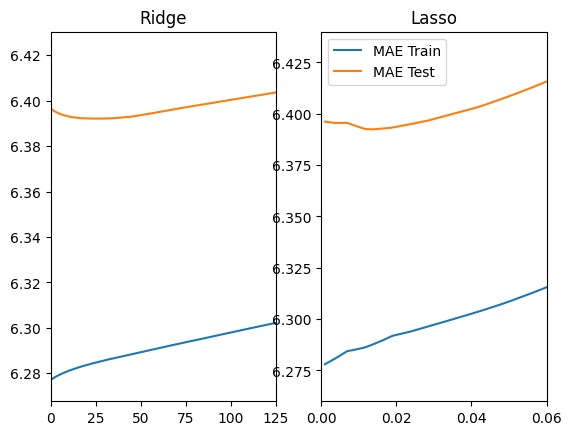

In [17]:
# Ridge and Lasso alpha testing
rmse_train_r, rmse_test_r, rmse_train_l, rmse_test_l = [], [], [], []
alphas = 2**np.arange(8,-10,-.05)
for alpha in alphas:
    rmse_train_ridge, rmse_test_ridge = RegRegression(Ridge(alpha = alpha, max_iter = 100000), X_train, X_test, y_train, y_test, rmse_train_r, rmse_test_r)
    rmse_train_lasso, rmse_test_lasso = RegRegression(Lasso(alpha = alpha, max_iter = 100000), X_train, X_test, y_train, y_test, rmse_train_l, rmse_test_l)
f, axarr = plt.subplots(1,2)
axarr[0].plot(alphas, rmse_train_ridge, label="MAE Train"), axarr[0].plot(alphas, rmse_test_ridge, label="MAE Test"), axarr[0].set_title('Ridge')
axarr[0].set_xlim([0, 125])
axarr[1].plot(alphas, rmse_train_lasso, label="MAE Train"), axarr[1].plot(alphas, rmse_test_lasso, label="MAE Test"), axarr[1].set_title('Lasso')
axarr[1].set_xlim([0, 0.06]), axarr[1].set_ylim([6.26, 6.44])
plt.legend()

In [13]:
# K-Fold cross validation for ridge and lasso
truth_ridge, preds_ridge = KFoldFunc(Ridge(alpha = 20, max_iter = 99999), X_TRAIN, y_TRAIN, True)
StatisticsObjective1(truth_ridge, preds_ridge)
print('\n')
truth_lasso, preds_lasso = KFoldFunc(Lasso(alpha = 0.015, max_iter = 99999), X_TRAIN, y_TRAIN, True)
StatisticsObjective1(truth_lasso, preds_lasso)

The RVE is:  0.1524112192132443
The rmse is:  7.463238776648172
The Correlation Score is is: 0.3905 (p-value=5.035122e-171)
The Maximum Error is is:  36.139046975677985
The Mean Absolute Error is:  6.3239194611882334


The RVE is:  0.1515405539155974
The rmse is:  7.467070700983543
The Correlation Score is is: 0.3893 (p-value=6.562255e-170)
The Maximum Error is is:  33.00612781571322
The Mean Absolute Error is:  6.328664558868266


In [14]:
# K-Fold Decision Tree Regressor
truth_tree, preds_tree = KFoldFunc(DecisionTreeRegressor(), X_TRAIN, y_TRAIN, False)
StatisticsObjective1(truth_tree, preds_tree)

The RVE is:  0.9268196337605098
The rmse is:  2.1930206294612353
The Correlation Score is is: 0.9636 (p-value=0.000000e+00)
The Maximum Error is is:  23.400999999999996
The Mean Absolute Error is:  0.6222174893617021


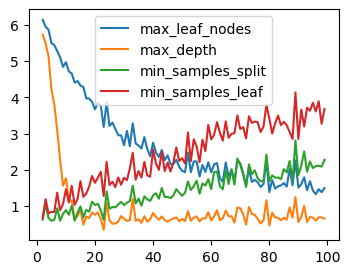

In [15]:
# Hyperparameter Optimization
hyperparam_opt(DecisionTreeRegressor, mean_absolute_error, 100, False)

In [17]:
# Good combo of hyperparameters
print("For max_depth=17:")
truth_tree, preds_tree = KFoldFunc(DecisionTreeRegressor(max_depth = 17), X_TRAIN, y_TRAIN, False)
StatisticsObjective1(truth_tree, preds_tree)
print("\nFor max_leaf_nodes=150:")
truth_tree, preds_tree = KFoldFunc(DecisionTreeRegressor(max_leaf_nodes = 150), X_TRAIN, y_TRAIN, False)
StatisticsObjective1(truth_tree, preds_tree)
print("\nFor max_leaf_nodes=150 & max_depth=17:")
truth_tree, preds_tree = KFoldFunc(DecisionTreeRegressor(max_depth = 17, max_leaf_nodes = 150), X_TRAIN, y_TRAIN, False)
StatisticsObjective1(truth_tree, preds_tree)

For max_depth=17:
The RVE is:  0.9269132895953848
The rmse is:  2.1915644029331625
The Correlation Score is is: 0.9636 (p-value=0.000000e+00)
The Maximum Error is is:  23.934999999999995
The Mean Absolute Error is:  0.6395562283601132

For max_leaf_nodes=150:
The RVE is:  0.9239411264299686
The rmse is:  2.235679858052082
The Correlation Score is is: 0.9617 (p-value=0.000000e+00)
The Maximum Error is is:  23.436647058823525
The Mean Absolute Error is:  1.1672730829857723

For max_leaf_nodes=150 & max_depth=17:
The RVE is:  0.9244934208382587
The rmse is:  2.2275795333579165
The Correlation Score is is: 0.9620 (p-value=0.000000e+00)
The Maximum Error is is:  23.436647058823525
The Mean Absolute Error is:  1.1608165725610535


In [24]:
# IVS results
unconstrained_model_IVS = DecisionTreeRegressor().fit(X_TRAIN, y_TRAIN)
preds_IVS = unconstrained_model_IVS.predict(X_IVS)
StatisticsObjective1(y_IVS, preds_IVS)

The RVE is:  0.9377653894146618
The rmse is:  2.049012796894714
The Correlation Score is is: 0.9688 (p-value=0.000000e+00)
The Maximum Error is is:  22.979
The Mean Absolute Error is:  0.5626146382978724


### Objective 2

In [28]:
# Data preparation
df = pd.read_csv('parkinsons_updrs.data')
y_column = df['total_UPDRS']
y_Park = np.array([int(i>40) for i in y_column])

X_Park_df = df.drop(["subject#", "motor_UPDRS", "total_UPDRS"], axis = 1)
X_Park = X_Park_df.values

In [29]:
# Train test split for basic model
X_TRAIN, X_IVS, y_TRAIN, y_IVS = train_test_split(X_Park, y_Park, test_size = 0.2, random_state = 123)
X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, y_TRAIN, test_size = 0.2, random_state = 123)

In [28]:
# Logistic Regression
truth_tree, preds_tree = KFoldFunc(LogisticRegression(), X_TRAIN, y_TRAIN, True)
StatisticsObjective2(truth_tree, preds_tree)

The Precision is:  0.4000
The Recall is:  0.0202
The F1 score is:  0.0384
The Matthews correlation coefficient is:  0.0571
The Confusion maxtrix is:
      0   1
0  3882  24
1   778  16


In [27]:
# K-Fold Decision Tree Classifier
truth_tree, preds_tree = KFoldFunc(DecisionTreeClassifier(), X_TRAIN, y_TRAIN, False)
StatisticsObjective2(truth_tree, preds_tree)

The Precision is:  0.9637
The Recall is:  0.9698
The F1 score is:  0.9667
The Matthews correlation coefficient is:  0.9599
The Confusion maxtrix is:
      0    1
0  3877   29
1    24  770


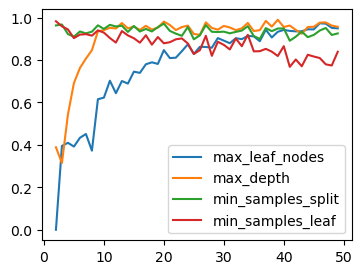

In [29]:
# Hyperparameter optimization
hyperparam_opt(DecisionTreeClassifier, f1_score, 50 , False)

In [30]:
# Good combo of hyperparameters
print("For max_depth=10:")
truth_tree, preds_tree = KFoldFunc(DecisionTreeClassifier(max_depth = 10), X_TRAIN, y_TRAIN, False)
StatisticsObjective2(truth_tree, preds_tree)
print("\nFor max_leaf_nodes=50:")
truth_tree, preds_tree = KFoldFunc(DecisionTreeClassifier(max_leaf_nodes = 50), X_TRAIN, y_TRAIN, False)
StatisticsObjective2(truth_tree, preds_tree)
print("\nFor max_leaf_nodes=50 & max_depth=10:")
truth_tree, preds_tree = KFoldFunc(DecisionTreeClassifier(max_depth = 10, max_leaf_nodes = 50), X_TRAIN, y_TRAIN, False)
StatisticsObjective2(truth_tree, preds_tree)

For max_depth=10:
The Precision is:  0.9614
The Recall is:  0.9093
The F1 score is:  0.9346
The Matthews correlation coefficient is:  0.9223
The Confusion maxtrix is:
      0    1
0  3877   29
1    72  722

For max_leaf_nodes=50:
The Precision is:  0.9740
The Recall is:  0.9433
The F1 score is:  0.9584
The Matthews correlation coefficient is:  0.9503
The Confusion maxtrix is:
      0    1
0  3886   20
1    45  749

For max_leaf_nodes=50 & max_depth=10:
The Precision is:  0.9608
The Recall is:  0.8955
The F1 score is:  0.9270
The Matthews correlation coefficient is:  0.9136
The Confusion maxtrix is:
      0    1
0  3877   29
1    83  711


In [31]:
# IVS results
unconstrainedClass_model_IVS = DecisionTreeClassifier().fit(X_TRAIN, y_TRAIN)
preds_IVS = unconstrainedClass_model_IVS.predict(X_IVS)
StatisticsObjective2(y_IVS, preds_IVS)

The Precision is:  0.9614
The Recall is:  0.9387
The F1 score is:  0.9499
The Matthews correlation coefficient is:  0.9391
The Confusion maxtrix is:
     0    1
0  955    8
1   13  199
